In [41]:
from utilities import *
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import accuracy_score

In [42]:
class Multilayer_perceptron:
    def __init__(self, X_train, y_train, X_test, y_test, n1, learning_rate=0.01, num_iterations=10000):
        # Initialisation des paramètres
        self.X = X_train.T
        self.y = y_train.T
        self.X_test = X_test.T
        self.y_test = y_test.T      
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        n0 = self.X.shape[0]
        n2 = self.y.shape[0]
        self.parametre = self.initialisation(n1, n0, n2)
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []

    def initialisation(self, n1, n0, n2):
        W_1 = np.random.randn(n1, n0) * 0.01  # Scaled weights for better convergence
        b_1 = np.zeros((n1, 1))  # Zero initialization for bias
        W_2 = np.random.randn(n2, n1) * 0.01
        b_2 = np.zeros((n2, 1))

        parametre = {
            'W1': W_1,
            'W2': W_2,
            'b1': b_1,
            'b2': b_2
        }
        return parametre

    def forward_propagation(self, X=None):
        # Allow passing X as parameter or use self.X by default pour le graph X_test
        if X is None:
            X = self.X
            
        W1 = self.parametre['W1']
        W2 = self.parametre['W2']
        b1 = self.parametre['b1']
        b2 = self.parametre['b2']
        
        Z1 = W1.dot(X) + b1
        Z1 = np.clip(Z1, -500, 500)  # Prevent overflow
        A1 = 1 / (1 + np.exp(-Z1))
        
        Z2 = W2.dot(A1) + b2
        Z2 = np.clip(Z2, -500, 500)  # Prevent overflow
        A2 = 1 / (1 + np.exp(-Z2))

        activations = {
            'A1': A1,
            'A2': A2
        }
        return activations

    def log_loss(self, A, y):
        # Calcul de la fonction de perte logistique
        m = y.shape[1]  # Number of examples
        A = np.clip(A, 1e-15, 1 - 1e-15)  # Prevent log(0)
        erreur = (-1 / m) * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
        return erreur

    def back_propagation(self, activation):
        # Calcul des gradients (dérivées)
        A1 = activation['A1']
        A2 = activation['A2']
        W2 = self.parametre['W2']
        m = self.y.shape[1]  # Parce qu'on transpose X et y au debut par facilité

        dz2 = A2 - self.y
        dw2 = (1/m) * dz2.dot(A1.T)
        db2 = (1/m) * np.sum(dz2, axis=1, keepdims=True)
        dz1 = W2.T.dot(dz2) * (A1 * (1 - A1))
        dw1 = (1/m) * dz1.dot(self.X.T)
        db1 = (1/m) * np.sum(dz1, axis=1, keepdims=True)

        gradients = {
            'dw1': dw1,
            'dw2': dw2,
            'db1': db1,
            'db2': db2
        }
        return gradients

    def update(self, gradient, learning_rate):
        W_1 = self.parametre['W1'] 
        W_2 = self.parametre['W2']
        b_1 = self.parametre['b1'] 
        b_2 = self.parametre['b2'] 

        W_1 = W_1 - learning_rate * gradient['dw1']
        W_2 = W_2 - learning_rate * gradient['dw2']
        b_1 = b_1 - learning_rate * gradient['db1']
        b_2 = b_2 - learning_rate * gradient['db2']

        self.parametre = { 
            'W1': W_1,
            'W2': W_2,
            'b1': b_1,
            'b2': b_2
        }
        return self.parametre
    
    def predict(self, X=None):
        # Allow passing X as parameter or use self.X by default
        if X is None:
            X = self.X
            
        activation = self.forward_propagation(X)
        A2 = activation['A2']
        return A2 >= 0.5

    def cost_plot(self):
        # Tracer l'évolution de la fonction de coût
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_train, label='Train Loss')
        plt.plot(self.loss_test, label='Test Loss')
        plt.xlabel("Nombre itérations")
        plt.ylabel("Cost")
        plt.legend()
        plt.title("Evolution de la fonction de perte")
        plt.show()
    
    def acc_plot(self):
        # Tracer l'évolution de l'accuracy'
        plt.figure(figsize=(10, 6))
        plt.plot(self.acc_train, label='Train Accuracy')
        plt.plot(self.acc_test, label='Test Accuracy')
        plt.xlabel("Nombre itérations")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Evolution de l'accuracy")
        plt.show()

    def gradient_descent(self):
        # Descente de gradient pour l'entraînement du modèle
        for i in tqdm(range(self.num_iterations)):
            if i % 100 == 0:
                # Train metrics
                activations_train = self.forward_propagation(self.X)
                self.loss_train.append(self.log_loss(activations_train['A2'], self.y))
                y_pred_train = self.predict(self.X)
                self.acc_train.append(accuracy_score(self.y.flatten(), y_pred_train.flatten()))
                
                # Test metrics
                activations_test = self.forward_propagation(self.X_test)
                self.loss_test.append(self.log_loss(activations_test['A2'], self.y_test))
                y_pred_test = self.predict(self.X_test)
                self.acc_test.append(accuracy_score(self.y_test.flatten(), y_pred_test.flatten()))
            
            # Training step
            activations = self.forward_propagation()
            gradients = self.back_propagation(activations)
            self.update(gradients, self.learning_rate)
        
        # Display results
        self.cost_plot()
        self.acc_plot()
        y_pred = self.predict(self.X_test)
        print(classification_report(self.y_test.flatten(), y_pred))
        return self.parametre

In [43]:
X_train, y_train, X_test, y_test = load_data()
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
MinMaxScaler = MinMaxScaler()
X_train_scaled = MinMaxScaler.fit_transform(X_train)
X_test_scaled = MinMaxScaler.fit_transform(X_test)

100%|██████████| 10000/10000 [02:06<00:00, 78.76it/s]


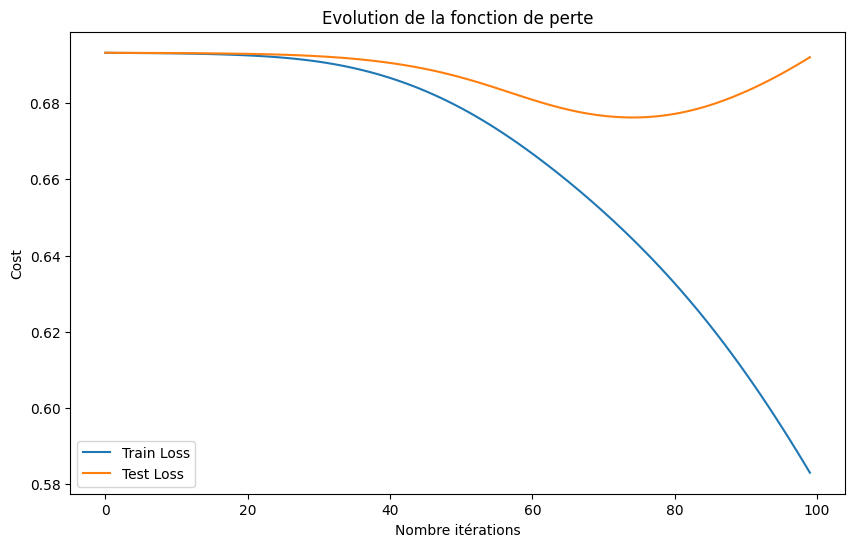

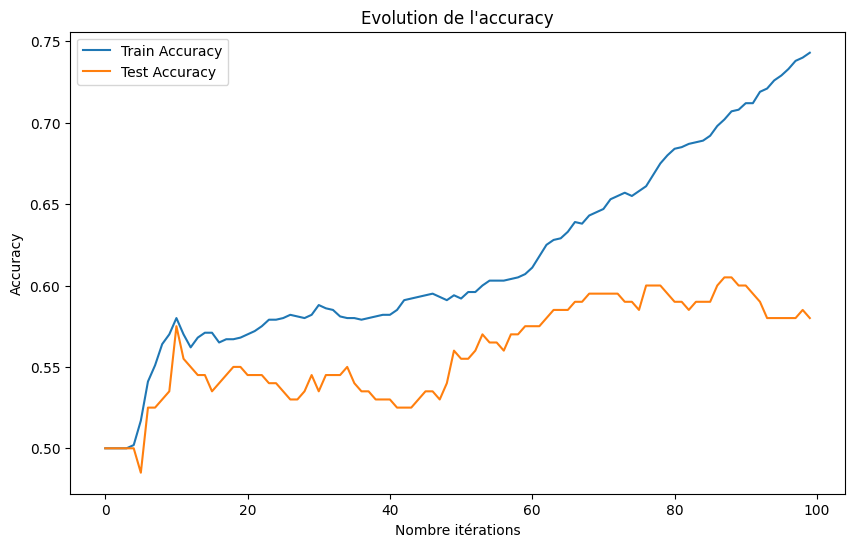

ValueError: Found input variables with inconsistent numbers of samples: [200, 1]

In [44]:
model = Multilayer_perceptron(X_train_scaled, y_train, X_test_scaled, y_test, 4)
model.gradient_descent()